# Creating Input for SHAP

**Important:** These technologies require versy specific software versions, so some libraries need to be uninstalled, reinstalled, then the runtime has to be recreated. Here are the instructions to do that, which you will want to do as soon as you start up the notebook: 

Run the first and second cells, then click Runtime > Restart Runtime. After that, click on the third cell  and then click Runtime > Run after. 

In [5]:
!/opt/conda/envs/python38/bin/python -m pip uninstall numpy
!/opt/conda/envs/python38/bin/python -m pip install numpy==1.19.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 8.2 MB/s eta 0:00:0000:0100:01


In [6]:
!/opt/conda/envs/python38/bin/python -m pip uninstall tensorflow
!/opt/conda/envs/python38/bin/python -m pip install tensorflow==1.14.0
# !pip install shap==0.31
!/opt/conda/envs/python38/bin/python -m pip install shap==0.34
!/opt/conda/envs/python38/bin/python -m pip install 'keras==2.2.3' --force-reinstall

ERROR: Could not find a version that satisfies the requirement tensorflow==1.14.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1)
ERROR: No matching distribution found for tensorflow==1.14.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.2/264.2 kB 764.8 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 MB 20.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 25.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 26.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [1]:
rootOfJupyterData = ""

try:
  import google.colab
  from google.colab import drive
  drive.mount('/content/drive')
  rootOfJupyterData = "/content/drive/MyDrive/Colab Notebooks/data/"
except: 
  rootOfJupyterData = "/home/jovyan/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import layers
import tensorflow as tf
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout

ModuleNotFoundError: No module named 'keras'

In [3]:
sampleOfData = pd.read_csv(rootOfJupyterData + 'onlyU737WithRedteam.csv')

In [4]:
def convertIDsToIntegers(df, dictOfIDs, columnName, starting_int):
  maxIDValue = starting_int

  dictionaryToReturn = {}

  for index, row in df.iterrows():
    currentKey = row[columnName]

    if currentKey not in dictOfIDs.keys():
      dictionaryToReturn[currentKey] = maxIDValue
      dictOfIDs[currentKey] = maxIDValue
      maxIDValue = maxIDValue + 1
    elif currentKey not in dictionaryToReturn.keys():
      dictionaryToReturn[currentKey] = dictOfIDs[currentKey]
    


  df[columnName] = df[columnName].map(dictionaryToReturn)
  return dictionaryToReturn,dictOfIDs, df, maxIDValue


def sequenceData(df):
  # df = df[:10000]
  # Put your inputs into a single list
  df['single_input_vector'] = df[["source computer", "destinationComputer", "authOrientation", "successFailure"]].apply(tuple, axis=1).apply(list)
  # Double-encapsulate list so that you can sum it in the next step and keep time steps as separate elements
  df['single_input_vector'] = df.single_input_vector.apply(lambda x: [list(x)])
  # Use .cumsum() to include previous row vectors in the current row list of vectors
  df['cumulative_input_vectors'] = df.single_input_vector.cumsum()
  df['output_vector'] = df[["isRedTeam"]].apply(tuple, axis=1).apply(list)

  max_sequence_length = 30
  # max_sequence_length = df.cumulative_input_vectors.apply(len).max()
  # Save it as a list   
  padded_sequences = pad_sequences(df.cumulative_input_vectors.tolist(), max_sequence_length).tolist()
  df['padded_input_vectors'] = (pd.Series(padded_sequences).apply(np.asarray))

  return df


def listSequence(nparray, seqLength):
  newSequence = []

  lenOfList = len(nparray)
  print(lenOfList)

  for x in range(0, lenOfList-1):
    newSequence.append(nparray[x:x+seqLength])

  newSequence = [item for sublist in newSequence for item in sublist]

  return np.asarray(newSequence)


def listSequenceWithoutFlatteningLastLayer(nparray, seqLength):
  newSequence = []

  lenOfList = len(nparray)
  print(lenOfList)

  for x in range(0, lenOfList-1):
    newSequence.append(nparray[x:x+seqLength])

  return newSequence
  # return np.asarray(newSequence) 


def getArraysForModel(copyOfEvents):
  df = copyOfEvents
  df = df.drop(labels='isRedTeam', axis=1)
  X_train = df# copyOfEvents[["source computer", "destinationComputer", "authOrientation", "successFailure"]]
  y_train = copyOfEvents["isRedTeam"]

  X_train_df = X_train
  y_train_df = y_train

  numOfRows = len(copyOfEvents.index)
  y = range(numOfRows)
  halfOfNumOfRows = round(numOfRows / 2)

  X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train , test_size=0.33, random_state=42)

  X_train_array = (X_train_split).values.tolist()
  X_test_array = (X_test_split).values.tolist()
  y_train_array = (y_train_split).values.tolist()
  y_test_array = (y_test_split).values.tolist()

  return X_train_array, X_test_array, y_train_array, y_test_array

## Creates a Second Model with Less Features

### Preprocessing and Dictionary Creation

In [5]:
just_events = sampleOfData.reindex(columns=['source computer', 'destinationComputer', 'authOrientation', 'successFailure', 'isRedTeam'])

In [6]:
just_events.head()

,source computer,destinationComputer,authOrientation,successFailure,isRedTeam
0,C2800,C1640,TGS,Success,False
1,C2800,C2800,TGS,Success,False
2,C2800,C2800,TGT,Success,False
3,C2800,TGT,TGS,Success,False
4,C2800,C2800,LogOn,Success,False


In [7]:
copyOfEvents = just_events
dictOfIDs = {} 

In [8]:
dictOfSourceComputerNames, dictOfIDs, copyOfEvents, startingID = convertIDsToIntegers(just_events, dictOfIDs, 'source computer', 2)
dictOfDestinationComputerNames, dictOfIDs, copyOfEvents, startingID = convertIDsToIntegers(just_events, dictOfIDs, 'destinationComputer', startingID)
dictOfAuthenticationOrientations, dictOfIDs, copyOfEvents, startingID = convertIDsToIntegers(just_events, dictOfIDs, 'authOrientation', startingID)
dictOfResults, dictOfIDs, copyOfEvents, largestID = convertIDsToIntegers(just_events, dictOfIDs, 'successFailure', startingID)
dictOfRedteam, dictOfIDs, copyOfEvents, throwaway = convertIDsToIntegers(just_events, dictOfIDs, 'isRedTeam', 0)

In [9]:
copyOfEvents.head()

,source computer,destinationComputer,authOrientation,successFailure,isRedTeam
0,2,123,158,164,0
1,2,2,158,164,0
2,2,2,124,164,0
3,2,124,158,164,0
4,2,2,159,164,0


In [10]:
dupCopy = copyOfEvents

Taking a look at the amount of Red Team events vs. Non-red Team, then creating a new dataframe with much less "good" events

In [11]:
justGoodEvents = copyOfEvents.loc[copyOfEvents['isRedTeam'] == 0]
justBadEvents = copyOfEvents.loc[copyOfEvents['isRedTeam'] == 1]

In [12]:
print(len(justGoodEvents.index))
print(len(justBadEvents.index))

55518
31


In [13]:
shortCopyOfEvents = pd.concat([justBadEvents, justGoodEvents.head(n=100)])
shortCopyOfEvents = shortCopyOfEvents.astype(np.float32)

Prepares data for input into the model

In [14]:
X_train_array, X_test_array, y_train_array, y_test_array = getArraysForModel(copyOfEvents)
X_train_array_short, X_test_array_short, y_train_array_short, y_test_array_short = getArraysForModel(shortCopyOfEvents)

In [15]:
print(X_train_array[0:30])

[[29, 114, 159, 164], [5, 5, 160, 164], [17, 17, 160, 164], [28, 19, 159, 164], [3, 3, 160, 164], [21, 21, 160, 164], [10, 24, 158, 164], [10, 24, 159, 164], [28, 4, 159, 164], [7, 7, 160, 164], [29, 114, 158, 164], [17, 17, 160, 164], [55, 6, 159, 164], [28, 8, 159, 164], [27, 17, 159, 164], [10, 6, 159, 164], [10, 9, 159, 164], [15, 15, 160, 164], [10, 3, 159, 164], [26, 26, 124, 164], [22, 22, 160, 164], [7, 7, 160, 164], [28, 7, 159, 164], [22, 22, 160, 164], [39, 142, 158, 164], [22, 22, 160, 164], [27, 22, 159, 164], [34, 34, 124, 164], [28, 129, 158, 164], [27, 5, 159, 164]]


In [16]:
X_train_array = listSequence(X_train_array, 30)
X_test_array = listSequence(X_test_array, 30)
y_train_array = listSequence(y_train_array, 30)
y_test_array = listSequence(y_test_array, 30)
X_train_array_short = listSequence(X_train_array_short, 30)
X_test_array_short = listSequence(X_test_array_short, 30)
y_train_array_short = listSequence(y_train_array_short, 30)
y_test_array_short = listSequence(y_test_array_short, 30)

37217
18332
37217
18332
87
44
87
44


In [17]:
print(len(X_train_array))

1116074


In [18]:
print(X_train_array[0:30])

[[ 29 114 159 164]
 [  5   5 160 164]
 [ 17  17 160 164]
 [ 28  19 159 164]
 [  3   3 160 164]
 [ 21  21 160 164]
 [ 10  24 158 164]
 [ 10  24 159 164]
 [ 28   4 159 164]
 [  7   7 160 164]
 [ 29 114 158 164]
 [ 17  17 160 164]
 [ 55   6 159 164]
 [ 28   8 159 164]
 [ 27  17 159 164]
 [ 10   6 159 164]
 [ 10   9 159 164]
 [ 15  15 160 164]
 [ 10   3 159 164]
 [ 26  26 124 164]
 [ 22  22 160 164]
 [  7   7 160 164]
 [ 28   7 159 164]
 [ 22  22 160 164]
 [ 39 142 158 164]
 [ 22  22 160 164]
 [ 27  22 159 164]
 [ 34  34 124 164]
 [ 28 129 158 164]
 [ 27   5 159 164]]


### Define and Run the LSTM model

In [19]:
from keras.layers.embeddings import Embedding
# inputs = layers.Input(shape=(4,))
# x = layers.Embedding(largestID, 100)(inputs)
# x = layers.LSTM(1200, recurrent_activation="relu")(x)
# x = layers.Dropout(0.1, seed=123456789)(x)
# x = layers.Dense(5000, activation="tanh") (x)
# outputs = layers.Dense(2, activation="softmax") (x)

# model = keras.Model(inputs=inputs, outputs=outputs, name="Relicating_Edos_model")
# model.summary()

model = keras.Sequential()
model.add(Embedding(largestID, 100))
model.add(keras.layers.LSTM(1200, recurrent_activation="relu"))
model.add(keras.layers.Dropout(0.1, seed=123456789))
model.add(keras.layers.Dense(5000, activation="tanh"))
model.add(keras.layers.Dense(2, activation="softmax"))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=["accuracy"]
)

history = model.fit(X_train_array[:500], y_train_array[:500], epochs = 1, batch_size = 7)



Epoch 1/1
500/500 [==============================] - 20s 39ms/step - loss: 0.3518 - acc: 0.9980


In [21]:
score, acc = model.evaluate(X_test_array[:500], y_test_array[:500],
                            batch_size=70)

500/500 [==============================] - 1s 1ms/step


In [22]:
# model.save(rootOfJupyterData + "model_with_all_U737_data.h5")

If you don't want to run the model and would prefer to read from an existing one, execute the cell below after uncommenting the code. 

In [23]:
# model = keras.models.load_model(rootOfJupyterData + 'model_with_all_U737_data.h5')

In [24]:
# modelPicture = rootOfJupyterData + "model3.png"
# keras.utils.plot_model(model, to_file=modelPicture, show_shapes=True)

## Creates SHAP objects using Model Data

In [25]:
# Given the model and some values of the training array, shap "tests" the model
# using those values and saves  
explainer = shap.DeepExplainer(model, X_train_array[:10])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test_array[:20])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"])

In [27]:
shap_values

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])]

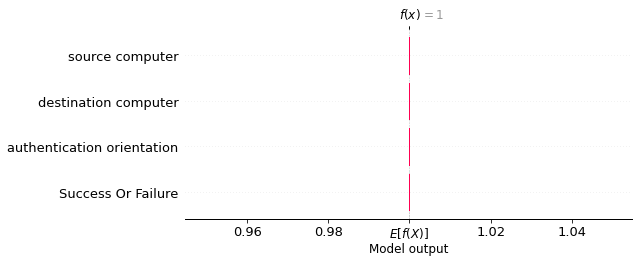

In [28]:
# shap.plots.waterfall(shap_values[0][0], max_display=14)
# shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"] )
shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"] )

Notice that the values do not make much sense. Why are they all 0 but some are going in the positive/negative direction?

In [29]:
print(shap_values[0][0])

[0. 0. 0. 0.]


The reason is because: SHAP has calculated values that are extremely close to 0. Initially I believe this was an error, but this is what happens when I create another model that is identical to the first but only uses about 150 events: 100ish "good" and 50ish red team.

In [30]:
modelWithLessData = keras.Sequential()
modelWithLessData.add(Embedding(largestID, 100))
modelWithLessData.add(keras.layers.LSTM(1200, recurrent_activation="relu"))
modelWithLessData.add(keras.layers.Dropout(0.1, seed=123456789))
modelWithLessData.add(keras.layers.Dense(5000, activation="tanh"))
modelWithLessData.add(keras.layers.Dense(2, activation="softmax"))

In [31]:
modelWithLessData.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=["accuracy"]
)

history = modelWithLessData.fit(X_train_array_short, y_train_array_short, epochs =1, batch_size = 1)

Epoch 1/1
2174/2174 [==============================] - 417s 192ms/step - loss: 0.3376 - acc: 0.8280


In [32]:
score, acc = modelWithLessData.evaluate(X_test_array_short, y_test_array_short,
                            batch_size=7)

884/884 [==============================] - 3s 4ms/step


In [33]:
print(score)

0.31326165795326233


In [34]:
print(acc)

0.6776018288677634


In [35]:
# modelWithLessData.save(rootOfJupyterData +  "model_with_some_U737_data.h5")

In [36]:
# modelWithLessData = keras.models.load_model(rootOfJupyterData + 'model_with_some_U737_data.h5')

In [37]:
# Given the model and some values of the training array, shap "tests" the model
# using those values and saves  
explainer = shap.DeepExplainer(modelWithLessData, X_train_array_short[:30])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test_array_short[:30])

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"])

In [38]:
shap_values

[array([[ 2.05495460e-01,  4.85638529e-03,  8.96481613e-02,
          0.00000000e+00],
        [ 2.84945513e-01,  1.50545085e-02,  0.00000000e+00,
          0.00000000e+00],
        [-4.80123274e-01, -5.53623872e-02, -1.64514313e-01,
          0.00000000e+00],
        [ 2.05495460e-01,  4.85638529e-03,  8.96481613e-02,
          0.00000000e+00],
        [ 2.96408771e-01,  3.59124612e-03,  0.00000000e+00,
          0.00000000e+00],
        [ 1.96995365e-01,  1.03004610e-01,  0.00000000e+00,
          0.00000000e+00],
        [ 1.98546788e-01,  1.53273772e-02,  8.61258090e-02,
          0.00000000e+00],
        [ 2.68564899e-01,  3.14351212e-02,  0.00000000e+00,
          0.00000000e+00],
        [ 4.26574728e-02,  1.15875376e-02,  2.45754991e-01,
          0.00000000e+00],
        [-4.54056085e-01, -8.88502952e-02, -1.57093667e-01,
          0.00000000e+00],
        [ 1.20226735e-01,  9.37738766e-02,  8.59994104e-02,
          0.00000000e+00],
        [-4.54056085e-01, -8.88502952e-02, -1.57093667e-01,
          0.00000000e+00],
        [ 2.05495460e-01,  4.85638529e-03,  8.96481613e-02,
          0.00000000e+00],
        [-5.17275372e-01,  5.83151563e-04, -1.83307803e-01,
          0.00000000e+00],
        [ 1.20226735e-01,  9.37738766e-02,  8.59994104e-02,
          0.00000000e+00],
        [ 1.67111823e-01,  1.32888184e-01,  0.00000000e+00,
          0.00000000e+00],
        [ 2.05495460e-01,  4.85638529e-03,  8.96481613e-02,
          0.00000000e+00],
        [ 1.98544121e-01,  1.51192705e-02,  8.63365908e-02,
          0.00000000e+00],
        [ 2.07576484e-01,  4.91658550e-04,  9.19318477e-02,
          0.00000000e+00],
        [ 2.80884410e-01,  1.91155916e-02,  0.00000000e+00,
          0.00000000e+00],
        [-4.80123274e-01, -5.53623872e-02, -1.64514313e-01,
          0.00000000e+00],
        [-4.43913249e-01, -8.50261172e-02, -1.71060644e-01,
          0.00000000e+00],
        [ 2.04012659e-01,  6.30288816e-03,  8.96844496e-02,
          0.00000000e+00],
        [-4.41032838e-01, -8.86444883e-02, -1.70322689e-01,
          0.00000000e+00],
        [ 2.04012659e-01,  6.30288816e-03,  8.96844496e-02,
          0.00000000e+00],
        [ 1.60735527e-01,  1.26342780e-01,  1.29216616e-02,
          0.00000000e+00],
        [ 1.86290834e-01,  3.13650482e-02,  8.23440929e-02,
          0.00000000e+00],
        [ 1.98546788e-01,  1.53273772e-02,  8.61258090e-02,
          0.00000000e+00],
        [ 2.05495460e-01,  4.85638529e-03,  8.96481613e-02,
          0.00000000e+00],
        [-4.47902127e-01, -1.01762595e-01, -1.50335214e-01,
          0.00000000e+00]]),
 array([[-2.05476983e-01, -4.85970887e-03, -8.96633029e-02,
          0.00000000e+00],
        [-2.84939161e-01, -1.50608081e-02,  0.00000000e+00,
          0.00000000e+00],
        [ 4.80135497e-01,  5.53446760e-02,  1.64519845e-01,
          0.00000000e+00],
        [-2.05476983e-01, -4.85970887e-03, -8.96633029e-02,
          0.00000000e+00],
        [-2.96403344e-01, -3.59667007e-03,  0.00000000e+00,
          0.00000000e+00],
        [-1.96996447e-01, -1.03003527e-01,  0.00000000e+00,
          0.00000000e+00],
        [-1.98526611e-01, -1.53333431e-02, -8.61400227e-02,
          0.00000000e+00],
        [-2.68555442e-01, -3.14445216e-02,  0.00000000e+00,
          0.00000000e+00],
        [-4.26721812e-02, -1.15878587e-02, -2.45739953e-01,
          0.00000000e+00],
        [ 4.54058115e-01,  8.88438879e-02,  1.57097975e-01,
          0.00000000e+00],
        [-1.20235029e-01, -9.37609038e-02, -8.60040625e-02,
          0.00000000e+00],
        [ 4.54058115e-01,  8.88438879e-02,  1.57097975e-01,
          0.00000000e+00],
        [-2.05476983e-01, -4.85970887e-03, -8.96633029e-02,
          0.00000000e+00],
        [ 5.17276460e-01, -5.85235393e-04,  1.83308786e-01,
          0.00000000e+00],
        [-1.20235029e-01, -9.37609038e-02, -8.60040625e-02,
          0.00000000e+00],
        [-1.67123228e-01, -1.32876785e-01,  0.00000000e+00,
          0.00000000e+0

In [39]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"])

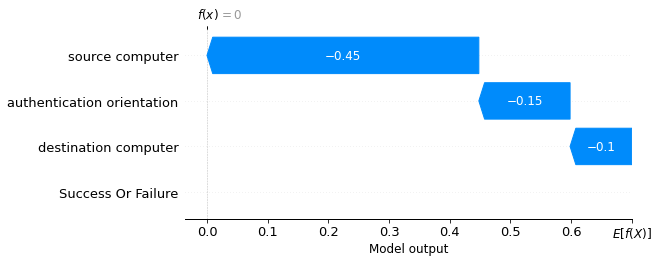

In [40]:
shap.waterfall_plot(explainer.expected_value[0], shap_values[0][29], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"] )

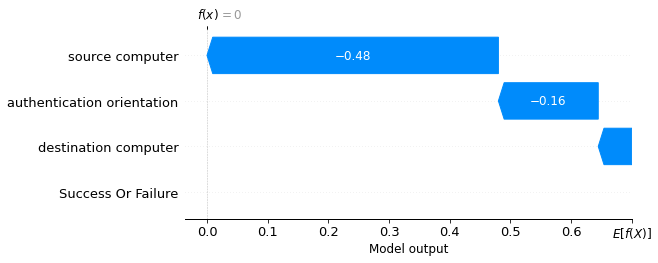

In [41]:
shap.waterfall_plot(explainer.expected_value[0], shap_values[0][20], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"] )

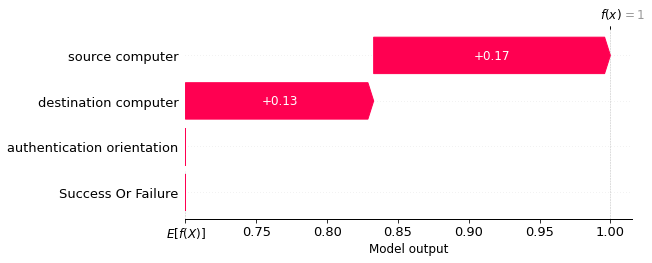

In [42]:
shap.waterfall_plot(explainer.expected_value[0], shap_values[0][15], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"] )

NOW we are seeing more reasonable results. My suspicion is that the first model "realized" that, in order to get the correct answer 99% of the time, it should just give a value of 0 as the output. After all, less than 1% of the data I fed it was a red team event. Now, the model is forced to find some other way to calculate the correct answer. 

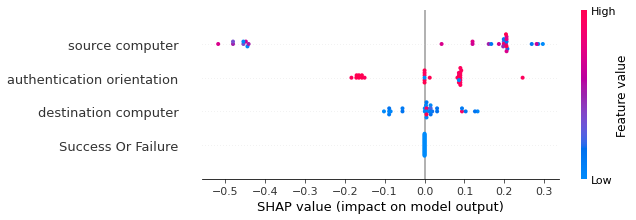

In [43]:
shap.summary_plot(shap_values[0], X_train_array[:30], feature_names=["source computer", "destination computer", "authentication orientation", "Success Or Failure"])

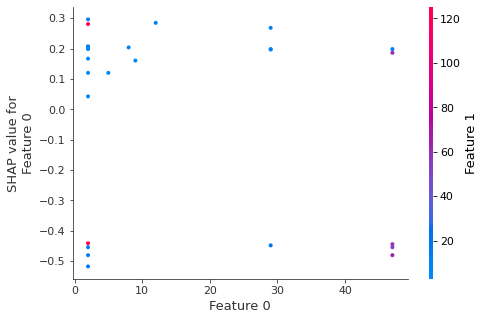

In [44]:
shap.dependence_plot('Feature 0', shap_values[0], X_train_array_short[:30] , interaction_index='Feature 1')